<a href="https://colab.research.google.com/github/molan-zhang/urban-octo-train/blob/master/Copy_of_Membership_Attack_annotated_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = 'content/drive/My Drive/Colab Notebooks/Cybersecurity/NN Attacks/'

Mounted at /content/drive


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root=project_path+'/data', train=False,
                                       download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 


Files already downloaded and verified
Files already downloaded and verified


 ship plane   cat  bird


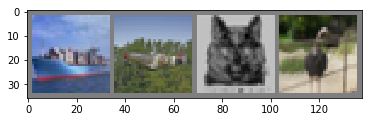

In [6]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images


In [7]:
# divide the training dataset into the required groups Make sure they are balanced

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 64

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) output of fc is 10 cuz we have 10 classes!



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels = 3, output channels=6, kernel_size =5 
        self.pool = nn.MaxPool2d(2, 2)  # kernel size = 2, stride = 2
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
# initalize a target model and train it

target_model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(target_model.parameters(), lr=0.01)

# let the magic begin
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = target_model(inputs) # make a prediction: forward prop
        
        loss = criterion(outputs, labels) # calculate the loss
        
        loss.backward() # calculate gradients
        
        optimizer.step() # updaate weights in backprop

        # print statistics
        running_loss += loss.item()
       
        
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training the Target model')

[1,    50] loss: 2.304
[1,   100] loss: 2.305
[1,   150] loss: 2.305
[2,    50] loss: 2.302
[2,   100] loss: 2.302
[2,   150] loss: 2.303
Finished Training the Target model


In [11]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        images, labels = data
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %




---



In [12]:
# initalize a Shadow Model and Train it
# for the first ICP trail use the same CNN architecture and hyperparameters

shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.SGD(shadow_model.parameters(), lr=0.0001)

# let the magic begin
for epoch in range(20):  # loop over the dataset multiple times

    shadow_running_loss = 0.0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = shadow_model(inputs) # make a prediction: forward prop
        
        shadow_loss = shadow_criterion(outputs, labels) # calculate the loss
        
        shadow_loss.backward() # calculate gradients
        
        shadow_optimizer.step() # updaate weights in backprop

        # print statistics
        shadow_running_loss += shadow_loss.item()
       
    print(shadow_running_loss / len(shadow_train_loader))
    shadow_running_loss = 0.0

print('Finished Training the Shadow model')

2.303216498725268
2.297934685434614
2.2851757638308468
2.223008378427856
2.1082073778522257
2.0052621364593506
1.9085368818166304
1.789306296377766
1.7210499078643566
1.6675348002083448
1.6263141327974748
1.6064707831460603
1.5834928203602225
1.5653910205072286
1.55091715953788
1.5268696382337688
1.5059006560821921
1.4840659523496822
1.4504571873314527
1.4467934452149334
Finished Training the Shadow model


In [0]:
# freeze the Shadow model 
shadow_model.eval()
shadow_output = []
# make predictions on both datasets (shadow_in and shdow_out)
with torch.no_grad():
  for i, data in enumerate(shadow_train_loader, 0) :
    inputs, labels = data
    output = shadow_model(inputs)
    for outputs_item in output:
      shadow_output.append([outputs_item,1])
  for i, data in enumerate(shadow_out_loader, 0) :
    inputs, labels = data
    output = shadow_model(inputs)
    for outputs_item in output:
      shadow_output.append([outputs_item,0])
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together
shadoww = torch.utils.data.DataLoader(shadow_output, batch_size=4,shuffle=True)


In [31]:
# create the Attack Model
# A NN binary classifier {0, 1}

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.sigmoid(self.fc1(x)))
        x = self.dropout(F.sigmoid(self.fc2(x)))
        x = self.dropout(F.sigmoid(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
      
# the input is a propability distribution and the output is 0 (out) or 1 (in in the training data)
attack_model = Classifier()
criterion = nn.NLLLoss()
attack_optimizer = optim.SGD(attack_model.parameters(), lr=0.001)
# let the magic begin
for epoch in range(20):  # loop over the dataset multiple times
  attack_running_loss = 0.0
  for data in shadoww:
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = attack_model(inputs) # make a prediction: forward prop
    attack_loss = criterion(outputs,labels) # calculate the loss
    attack_loss.backward() # calculate gradients
    attack_optimizer.step() # updaate weights in backprop
    attack_running_loss += attack_loss.item()
  print(attack_running_loss / len(shadoww))   
  attack_running_loss = 0.0

print('Finished Training the attack model')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9789749527704715
1.3281725533698499
0.9494186792999506
1.071367412906885
1.3087977059513332
1.4482177091009543
1.5079901450260356
1.6394109229839966
2.119437985195685
2.180929435651591
1.2304893439815938
1.067216466217041
0.9036577116855979
1.7373417623674776
2.590783707565558
2.264846880475171
2.952036891312986
4.842065497534474
4.109669561075697
4.567245050781882
Finished Training the attack model


In [54]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluare the attack model

accuracy = 0
equals = 0
with torch.no_grad():
  attack_model.eval()
  for data in target_out_loader:
    inputs, labels = data
    outputs = target_model(inputs)
    ans = attack_model(outputs)
    for i in ans :
      equals = 0
      if i[0] > i[1] :
        equals += 1
    accuracy += equals / len(ans)
  for data in target_train_loader:
    inputs, labels = data
    outputs = target_model(inputs)
    ans = attack_model(outputs)
    for i in ans :
      equals = 0
      if i[0] < i[1] :
        equals += 1
    accuracy += equals / len(ans)
  accuracy = accuracy / (len(target_out_loader)+len(target_train_loader)) * 100
print(accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


7.900191326530613


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?